
$$\newcommand{\vec}[1]{{\bf #1} } 
\newcommand{\real}{\mathbb{R} }
\newcommand{\expect}[1]{\mathbb{E}[#1] }
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\argmax}{arg\,max}
\newcommand{\E}{\mathbb{E}}$$
<img src="imgs/chi2019_logo_final.png">

# CHI 2019 Course on Bayesian Methods in Computational Interaction

# Part 3: Introduction to Bayesian Optimization in HCI

---
## Antti Oulasvirta and Tomi Peltola / Aalto University 

* antti.oulasvirta@aalto.fi / [Aalto User Interfaces group](http://userinterfaces.aalto.fi)
* tomi.peltola@aalto.fi / Probabilistic Machine Learning group / [Homepage](http://www.tmpl.fi)

[Original slides from a lecture at Aalto by Tomi Peltola](http://www.tmpl.fi/bayesian-optimization/slides.Rmd)


## Learning goals

This is practically oriented lecture for HCI researchers and practitioners. After this lecture and the exercises, you should

 1. understand the basics of Bayesian optimization and its applications in HCI,
 2. be able to assess when it can be a useful tool and when not,
 3. know how to use the GPyOpt Python package for your own applications.


## Table of contents

 1. Introduction
 2. Bernoulli bandit
 3. Bayesian optimization 
 4. Acquisition functions
 5. Application example
 6. Conclusion

---
# 1. Introduction

<p>
<div class="alert alert-block alert-success"> 
<h3>In-class exercise.</h3> 
<br>
Ask your friend to pick two or three favorite colors. You would like to figure ou what they are, **but** you can only ask about one color at a time. When asked about a color, the friend must tell how liked it is on a scale from 1 to 5 (best). If you only have 8 questions, **how** should you choose which color to ask?</div>
</p>


## Overview 
Bayesian optimization is a modern approach to **global optimization**. It is robust and sample-efficient and well-suited for noisy, expensive evaluative functions. It uses a **surrogate model** for approximating the model fit across the parameter space.  Posteriori probability provides an intuitive quantification of acquired knowledge of the best parameter values given the available observation data. Another core idea is to use an **acquisition rule** for selecting which parameter values are used for generating predictions, based on the surrogate model. Inference is performed through a sequence of optimization rounds. 

Recipe:

- At the beginning of each round, the acquisition rule is used to select a set of parameter values that will be used to generate predictions. The locations are balanced such that they cover both unknown regions of the parameter space (**exploration**) and regions with high probability to lead to good model fit (**exploitation**). 
- After predictions have been generated at each location, the surrogate model is updated based on the observed model fits, and the next optimization round begins. 
- The final parameter estimates are often chosen to be the parameter values that lead to best predicted model fit on average.

[Visual overview](imgs/bo-overview.png).
Source: https://towardsdatascience.com

**Compare: Grid search** assumes that the optimal parameter values are contained within some bounded region of the parameter space. Then divide this bounded parameter space into a large number of smaller cells, often by using an even grid. Then, for each grid cell, a dataset is generated using the parameter values at the cell, and finally the parameter values that yielded the best model fit are used as the final estimate.

## Problem

Find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

**How would you solve this?**

 * Hand-tuning / trial and error,
 * random search,
 * grid search,
 * gradient descend,
 * evolutationary algorithms,
 * different types of programming (linear, integer, etc.),
 * ...


## Application - A/B testing

But what if... $f$ 

 * can only be evaluated implicitly,
 * with a lot of noise.
 
For example, optimize for click-through rate, retention time, or purchases, implicitly measuring user satisfaction, interest, or revenue of different version of a web site.

By choosing conditions wisely, Bayesian optimization can converge to a good design quicker and avoid contaminating users with potentially bad designs.

## Application - Computational design

But what if ... $f$ 

 * is a black-box (e.g., contains human judgement),
 * with noisy and expensive/slow evaluations,
 * and multi-modal.

For example, optimizing parameters for procedural animation generation by asking humans to rate generated examples.

<div class="center">
<img src="imgs/anim.png" style="width: 50%" />
</div>

<div style="font-size: 10px;"><a href="https://dl.acm.org/citation.cfm?id=1921443">[image: Brochu et al., 2010]</a></div>

## Application - Adaptive interfaces

But what if ... $f$ 

 * is based on an implicit signal from human,
 * with noisy and expensive/slow evaluations.

For example, optimizing step rate to minimize metabolic cost.

<div class="center">
<img src="imgs/wearable_devices.png" style="width: 70%" />
</div>

<div style="font-size: 10px;"><a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0184054">[image: Kim et al., 2017]</a></div>


## Application - Inverse modeling

But what if ... $f$ 

 * contains a parametric simulator,
 * with noisy and expensive/slow evaluations.

For example, fitting parameters of cognitive simulators to experimental data.

<div class="center">
<img src="imgs/abc2.png" style="width: 60%" />
</div>

<div style="font-size: 10px;"><a href="https://dl.acm.org/citation.cfm?doid=3025453.3025576">[image: Kangasraasio et al., 2017]</a></div>


## Application - Others

 * Recommender systems
 * Sensor networks
 * AutoML: automatic tuning of machine learning models
 * Robotics and reinforcement learning

## The computational problem

**Problem:** Find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

**Challenges**
 * $f$ is a black-box that we can only evaluate point-wise, 
 * $f$ can be multi-modal,
 * $f$ is slow or expensive to evaluate,
 * evaluations of $f$ are noisy,
 * $f$ has no gradients available (can be used if available).

** Basic idea of BO **

We want to find the minimum with small number of evaluations of $f$. Solution:

 1. Construct a tractable **statistical surrogate model** of $f$.
 2. Turn the optimization problem into **a sequence of easier problems**.

---

# 2. Bernoulli bandit

*To link Bayesian optimization to the previous lectures, we look at a simpler, so-called bandit problem first.*

**Task**: Conduct an A/B test to find which of two versions of a Web ad is better; that is, which ad gets most clicks.

Nomenclature:
 * **Experiment**: Show one of the two versions to a visitor.
 * **Observation**: Did the visitor click the ad.
 
Minimize *regret* $R$ for $T$ experiments:
$$R = T \E[y^*] - \sum_{t=1}^T y_t$$
 * $\E[y^*]$ is the expected click rate for the better ad,
 * $y_t \in \{0,1\}$ is whether visitor $t$, who was shown version $x_t \in \{A, B\}$, clicked the ad.

 * Model click rates of $A$ and $B$ independently. Equations for A below.
 
**Bayes theorem**: $p(\theta \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid \theta)}{p(\mathcal{D})}  p(\theta)$

updates **prior** knowledge $p(\theta)$ with **observations** $\mathcal{D}$ to **posterior** knowledge $p(\theta \mid \mathcal{D})$.

Observation model:

$$\Pr(y_t \mid x_t = A) = \textrm{Bernoulli}(y_t \mid \rho_A) = \rho_A^{y_t} (1 - \rho_A)^{1-y_t}.$$

Prior model:

$$p(\rho_A) = \textrm{Beta}(\rho_A \mid \alpha, \beta) = \frac{1}{B(\alpha, \beta)} \rho_A^{\alpha-1} (1 - \rho_A)^{\beta-1}.$$

Given a dataset of $t$ observations $\mathcal{D}_t = \{(x_1, y_1), \ldots, (x_t, y_t)\}$, the posterior distribution is
$$p(\rho_A \mid \mathcal{D}_t) = \frac{p(\rho_A) \prod_{t: x_t = A} \Pr(y_t \mid x_t = A)}{\int_0^1 p(\rho_A) \prod_{t: x_t = A} \Pr(y_t \mid x_t = A) d\rho_A} = \textrm{Beta}(\rho_B \mid \alpha + n^{A}_1, \beta + n^{A}_0),$$
where $n^{A}_1$ and $n^{A}_0$ are the total numbers of $y_t = 1$ and $y_t = 0$ for $x_t = A$.



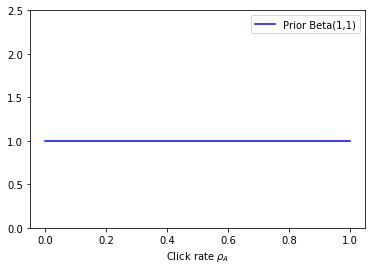

In [3]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

x = np.linspace(0, 1, 101)

plt.plot(x, scipy.stats.beta.pdf(x, 1, 1), 'b-', label='Prior Beta(1,1)')
plt.xlabel(r'Click rate $\rho_A$')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

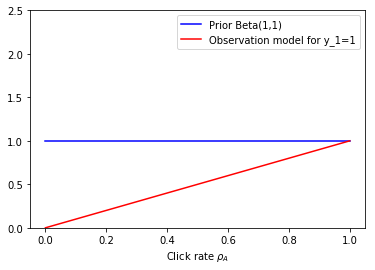

In [4]:
plt.figure()
plt.plot(x, scipy.stats.beta.pdf(x, 1, 1), 'b-', label='Prior Beta(1,1)')
plt.plot(x, x, 'r-', label='Observation model for y_1=1')
plt.xlabel(r'Click rate $\rho_A$')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

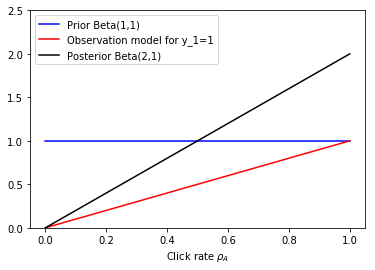

In [3]:
plt.figure()
plt.plot(x, scipy.stats.beta.pdf(x, 1, 1), 'b-', label='Prior Beta(1,1)')
plt.plot(x, x, 'r-', label='Observation model for y_1=1')
plt.plot(x, scipy.stats.beta.pdf(x, 2, 1), 'k-', label='Posterior Beta(2,1)')
plt.xlabel(r'Click rate $\rho_A$')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

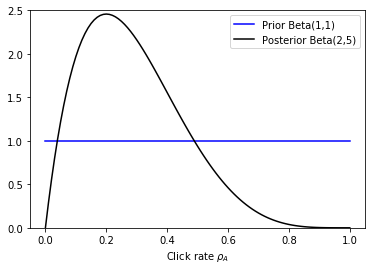

In [4]:
plt.figure()
plt.plot(x, scipy.stats.beta.pdf(x, 1, 1), 'b-', label='Prior Beta(1,1)')
plt.plot(x, scipy.stats.beta.pdf(x, 2, 5), 'k-', label='Posterior Beta(2,5)')
plt.xlabel(r'Click rate $\rho_A$')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## Thompson sampling

When $t+1$th visitor comes, which ad, $A$ or $B$, to serve?

 * Want to exploit: gather as much clicks as possible.
 * Need to explore: learn about click rates for $A$ and $B$.
 
Thompson sampling is a simple algorithm navigating this trade-off:

 1. Sample a value for $\hat{\rho}_A$ and for $\hat{\rho}_B$ from $p(\rho_A \mid \mathcal{D}_t)$ and $p(\rho_B \mid \mathcal{D}_t)$.
 2. Show $A$ if $\hat{\rho}_A > \hat{\rho}_B$ and $B$ otherwise.
 
We then observe whether the visitor clicked the ad or not and update our posterior distributions and continue to next iteration.

## Example 
*How does Thompson sampling navigate exploration-exploitation trade-off?*

In [ ]:

rho_A_true = 0.1; rho_B_true = 0.2 # simulated visitor click rates
alpha = 1; beta = 1 # prior parameters
n_A1 = 0; n_A0 = 0; n_B1 = 0; n_B0 = 0 # numbers of clicks/no-clicks
T = 1000 # number of iterations
clicks = np.zeros(T); A_or_B = np.zeros(T)

for t in range(T):
    # Thompson sampling
    rho_A = np.random.beta(alpha + n_A1, beta + n_A0)
    rho_B = np.random.beta(alpha + n_B1, beta + n_B0)
    if rho_A > rho_B: # which ad to show
        y_t = np.random.binomial(1, rho_A_true) # simul. click
        n_A1 += y_t; n_A0 += 1 - y_t; # update posterior of A
    else:
        y_t = np.random.binomial(1, rho_B_true) # simul. click
        n_B1 += y_t; n_B0 += 1 - y_t; # update posterior of B
    # collect statistics
    clicks[t] = y_t; A_or_B[t] = rho_A > rho_B
    
# instead of Thompson sampling, allocate same numbers to A and B
clicks_half = np.zeros(T)

for t in range(T):
    if t % 2 == 0:
        y_t = np.random.binomial(1, rho_A_true)
    else:
        y_t = np.random.binomial(1, rho_B_true)
    clicks_half[t] = y_t
    
plt.figure()
plt.plot(range(1,T+1), np.cumsum(clicks), 'r-', label='Thompson sampling')
plt.plot(np.array(range(1,T+1))[A_or_B==1], np.cumsum(clicks)[A_or_B==1], 'k.', label='Thompson sampling chose A')
plt.plot(range(1,T+1), np.cumsum(clicks_half), 'b-', label='Half A, half B')
plt.plot(range(1,T+1), np.array(range(1,T+1)) * rho_B_true, 'k-', label='Always B (theoretical average)')
plt.xlabel('iterations')
plt.ylabel('Cumulative number of clicks')
plt.legend(loc=2)
plt.show()

# 3. Bayesian Optimization

## Task

Find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

Want to find the minimum with small number of evaluations of $f$.

 1. **Construct a tractable statistical surrogate model of $f$.**
 2. Turn the optimization problem into a sequence of easier problems.

## Surrogate models

"A **surrogate model** is an engineering method used when an outcome of interest cannot be easily directly measured, so a model of the outcome is used instead." (Wikipedia)
 
Let $g(x)$ be our **surrogate model** of $f$.

 * $g$ should be able to capture important aspects of $f$ from small number of evaluations.
 * Need to be able to update $g$ when we acquire new evaluations of $f$: $g$ should get better and better as a model of $f$.
 * $g$ should be fast to evaluate and to update.
 * $g$ needs to cope with noise.
 * Need to be able to quantify uncertainty in $g$ (navigating exploration-exploitation tradeoff).

## Gaussian processes

Gaussian process (GP) regression models are commonly used surrogate models used in BO. This is because of its capacity to approximate a large subset of model fit surfaces that are encountered in practice. GP models are also able to model the stochasticity of model fit, thus allowing a principled estimation of its mean and variance everywhere in the parameter search space.

 * Gaussian processes provide a probability distribution over functions.
 * Extends (and uses properties of) the multivariate normal distribution $\Rightarrow$ computationally tractable.
 * Prior information about the type or behaviour of the modelled function can be included in the *covariance function* and its parameters.
 
 * Alternatives: random forests, Bayesian neural networks.
 
<p>
<div class="alert alert-block alert-success"> 
<h3>In-class exercise.</h3> 
<br>
Open the [Interactive demo app](http://www.tmpl.fi/bayesian-optimization/#37). Add observations to the plot. Then create a covariance function with a) length scale and b) noise parameters. Fiddle with the parameters to find the best combination. Length scale describes "how close" two points have to be to influence each other.</div>
</p>
<div id="gp-outer"></div>


## Turn the optimization problem into a sequence of easier problems

Consider having evaluated $f$ at points $x_1, \ldots, x_{t-1}$ and having constructed $p(g \mid \mathcal{D}_{t-1})$.

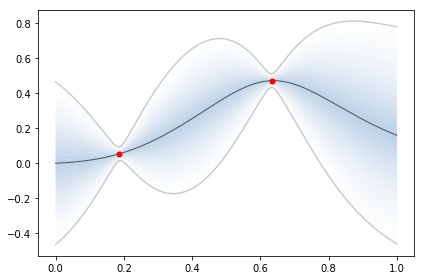

In [5]:
import GPy; import GPyOpt

def f_u(x):
    return x**2 + 0.1 + 0.1 * np.random.randn()
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]
myBopt = GPyOpt.methods.BayesianOptimization(
    f=f_u, domain=bounds, acquisition_type='EI',
    exact_feval = False, initial_design_numdata=2, normalize_Y=False)
max_iter = 0; max_time = 60; eps = 10e-6

myBopt.run_optimization(max_iter, eps)
myBopt._update_model()
#myBopt.plot_acquisition()
#myBopt.model.model.plot([0.0,1.0])
model = myBopt.model.model

x_grid = np.arange(0, 1, 0.001)
x_grid = x_grid.reshape(len(x_grid),1)
m, v = model.predict(x_grid)

model.plot_density([0,1], alpha=.5)

plt.plot(x_grid, m, 'k-',lw=1,alpha = 0.6)
plt.plot(x_grid, m-1.96*np.sqrt(v), 'k-', alpha = 0.2)
plt.plot(x_grid, m+1.96*np.sqrt(v), 'k-', alpha=0.2)

Xdata, Ydata = myBopt.get_evaluations()

plt.plot(Xdata, Ydata, 'r.', markersize=10)

plt.show()

How to choose the next $x$ to evaluate $f$ at?

**What would you do?**

Consider having evaluated $f$ at points $x_1, \ldots, x_{t-1}$ and having constructed $p(g \mid \mathcal{D}_{t-1})$:

In [13]:
plt.figure()
myBopt.plot_acquisition()

NameError: name 'myBopt' is not defined

<Figure size 432x288 with 0 Axes>

---- 
# 4. Acquisition functions 
How to choose the next $x$ to evaluate $f$ at?

**Guided exploration** using $p(g \mid \mathcal{D}_{t-1})$:

 * Trade off exploration (reducing uncertainty) and exploitation (sampling near likely places of optima).
 * Formulated by maximizing an acquisition function $\alpha(x; \mathcal{D}_{t-1})$.
 
$$x_{t} = \argmax_x \alpha(x; \mathcal{D}_{t-1})$$

**Thompson sampling** acquisition function:

 * $\alpha(x; \mathcal{D}_{t-1}) = \hat{g}(x)$, where $\hat{g}(x)$ is a sample from $p(g \mid \mathcal{D}_{t-1})$.

**Expected improvement** acquisition function:

 * Currently best value $y^* = \max_{s \in \{1,\ldots,t-1\}} y_s$.
 * Improvement function provides utility of $x$ given $g$: $I(x, g) = (g(x) - y^*) I(g(x) > y^*)$.
 * Expected improvement: $\alpha_{EI}(x; \mathcal{D}_t) = \E_g[I(x, g)]$.

Many others also exists.

## Bayesian Optimization Recipe

**Goal**: Find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

**Key ideas**

 1. Construct a tractable statistical surrogate model of $f$.
 2. Turn the optimization problem into a sequence of easier problems.

**Algorithm**

 1. Initialize dataset $\mathcal{D}_0$, surrogate model $p(g \mid \mathcal{D}_0)$; choose acquisition function $\alpha(\cdot)$.
 2. Loop for $t = 1,2,\ldots,T$:
      1. Select next evaluation point: $x_{t} = \argmax \alpha(x; \mathcal{D}_{t-1})$.
      2. Evaluate $f(x_{t})$ to obtain $y_{t}$.
      3. Update dataset $\mathcal{D}_{t} = \{\mathcal{D}_{t-1},(x_t, y_t)\}$.
      4. Update surrogate model $p(g \mid \mathcal{D}_t)$.
 3. Report the found optimum.
 

## GPyOpt

In [ ]:
def f_u(x):
    return 0.2 * (x - 0.3)**2 - 0.4 * np.sin(15.0 * x)

plt.figure(); xx = np.linspace(0, 1, 101)
plt.plot(xx, f_u(xx), 'k-'); plt.show()

In [ ]:
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]
myBopt = GPyOpt.methods.BayesianOptimization(
    f=f_u, domain=bounds,        # Function and domain                 
    acquisition_type='EI',       # Expected improvement
    exact_feval=True,            # Noiseless function evaluations
    eps=1e-6,
    normalize_Y=False,           # (for clearer visualization)
    initial_design_numdata=2)    # (for clearer visualization)

In [ ]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

In [ ]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

In [ ]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

In [ ]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

In [ ]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

## Does it work?

 * Theoretical guarantees (regret bounds) exists under some conditions.
 * ''There is still a wide gap between theory and practice.'' - Shahriari et al.

''[...]the careful choice of statistical model is often far more important than the choice of acquisition function heuristic.'' - Shahriari et al.

**Some limitations**

 * Difficult for high-dimensional spaces.
 * Can spend a lot of time on the edges of the space (Siivola et al., MLSP 2018).
 * Computation complexity of inference in Gaussian processes scales as $O(N^3)$, where $N$ is the number of observations (sparse GPs/inducing point approximations can be used; or other types of models).
 * Optimizing hyperparameters (controlling the behaviour of the surrogate) can be challenging.

---

# 5. Application example

Two types of rather direct human-in-the-loop applications:
 * Human provides explicit feedback at $x$, the value $f(x)$.
 * Human provides implicit feedback at $x$, for example, $f(x)$ is a completion time of a task with parameters $x$.

## Animation design

Find parameters for generating a procedural fluid animation:
* velocity, radius and magnitude of the (possibly multiple) vortex rings,
* length scale and magnitude of the curl noise,
* relative strengths of vortex rings and curl noise.

User can easily tell which animations look good: ''the psychoperceptual process underlying judgment - how well a realization fits what the user has in mind''.

<div class="center">
<img src="imgs/anim.png" style="width: 50%" />
</div>

*Eric Brochu, Tyson Brochu, Nando de Freitas: A Bayesian Interactive Optimization Approach to Procedural Animation Design, Eurographics/ACM SIGGRAPH Symposium on Computer Animation (2010).*

### User interface
<div class="center">
<img src="imgs/ui.png" style="width: 79%" />
</div>

### Algorithm
<div class="center">
<img src="imgs/bo_alg.png" style="width: 79%" />
</div>

### User study
 * Obtained improved results compared to novice and expert users setting parameters manually.
 * Tailored the Bayesian optimization approach to make it work:
      1. preferential feedbacks,
      2. transfer information over multiple sessions,
      3. com-bined manual parameter tuning and Bayesian optimization.
      

---
# In-class exercise: Eliciting color preferences

<p>
<div class="alert alert-block alert-success"> 
<h3>In-class exercise.</h3> 
<br>
Below is a script that implements the color preference elicitation problem. Unfortunately, it is not very good; that is, it does not get a good preference model in 8 questions. Can you figure out how to improve it?  
<br>
<b>Tip:</b> Can you improve the acquisition function? Three things to try are: 
‘EI’, expected improvement;
‘MPI’, maximum probability of improvement; and
‘LCB’, GP-Lower confidence bound. 
[Manual page](https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html)
</div>
</p>




In [ ]:
def f_u(x):
    plt.figure(1)
    print(x)
    im = x.reshape(1, 1, 3).repeat(3, axis=0).repeat(3, axis=1)
    plt.imshow(im)
    plt.show(block=False)
    while True:
        res = input('Grade? (0 to 5) ')
        if res in ['0', '1', '2', '3', '4', '5']:
            res = int(res)
            plt.close(1)
            return res


def run_bo(max_iter):
    bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0, 1)},
              {'name': 'var_2', 'type': 'continuous', 'domain': (0, 1)},
              {'name': 'var_2', 'type': 'continuous', 'domain': (0, 1)}]
    myBopt = GPyOpt.methods.BayesianOptimization(
        f=f_u, domain=bounds,
        acquisition_type='MPI',
        exact_feval=False,
        eps=1e-6,
        normalize_Y=False,
        initial_design_numdata=2,
        maximize=True)
    myBopt.run_optimization(max_iter=max_iter - 2)

    return myBopt


def run_random(max_iter):
    xs = np.zeros((max_iter, 3))
    ys = np.zeros((max_iter,))

    for i in range(max_iter):
        xs[i, :] = np.random.rand(3)

        ys[i] = f_u(xs[i, :])

    return xs, ys


if __name__ == "__main__":
    n_iter = 8
    # run BO
    bo = run_bo(n_iter)
    # run random for comparison
    ra = run_random(n_iter)

    bo_xs, bo_ys = bo.get_evaluations()
    ra_xs, ra_ys = ra

    # one can investigate these to see how good colors were found and compare
    # to a ground truth color

    plt.plot(-bo_ys, 'k-', label='BO')
    plt.plot(ra_ys, 'r-', label='Random')
    plt.xlabel('iterations')
    plt.ylabel('grades')
    plt.legend()
    plt.show()

    # let's say ground truth color was red
    x_gt = np.array([1.0, 0.0, 0.0])

    plt.plot(np.sqrt(np.sum((bo_xs - x_gt)**2, 1)), 'k-', label='BO')
    plt.plot(np.sqrt(np.sum((ra_xs - x_gt)**2, 1)), 'r-', label='Random')
    plt.xlabel('iterations')
    plt.ylabel('distance from ground truth')
    plt.legend()
    plt.show()



---

# 6. Conclusion 

## Summary
Find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

 * $f$ is a black-box that we can only evaluate point-wise, 
 * $f$ can be multi-modal,
 * $f$ is slow or expensive to evaluate,
 * evaluations of $f$ are noisy,
 * $f$ has no gradients available (can be used if available).

**Key ideas**

 1. Construct a tractable statistical surrogate model of $f$, with proper uncertainty quantification.
 2. Turn the optimization problem into a sequence of easier problems, navigating the exploration-exploitation tradeoff.


**Wide range of applications**. Relevant for HCI and human-in-the-loop modelling.

Many **software implementations** (e.g., GPyOpt) exists. Relatively easy to start using.

## Readings
 * <a href="https://ieeexplore.ieee.org/document/7352306">Shahriari et al., **Taking the Human Out of the Loop: A Review of Bayesian Optimization**, Proceedings of the IEEE, 2016.</a>
 * <a href="http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb">Cam Davidson-Pilon, **Chapter 1: Introduction to Bayesian Methods from Bayesian Methods for Hackers**.<a/>
 * <a href="http://www.gaussianprocess.org/gpml/">Rasmussen, Williams, **Gaussian Processes for Machine Learning**, MIT Press, 2016.</a>
 * <a href="http://sheffieldml.github.io/GPyOpt/">GPyOpt, Python package for Bayesian optimization.</a>
 * <a href="http://www.tmpl.fi/gp/">Interactive Gaussian process regression demo.</a>
 * <a href="https://dl.acm.org/citation.cfm?id=1921443">Brochu et al., **A Bayesian Interactive Optimization Approach to Procedural Animation Design**, Eurographics/ACM SIGGRAPH Symposium on Computer Animation, 2010.</a>.
 * <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0184054">Kim et al., **Human-in-the-loop Bayesian optimization of wearable device parameters**, PLOS ONE, 2017.</a>
 * <a href="https://dl.acm.org/citation.cfm?doid=3025453.3025576">Kangasraasio et al., **Inferring Cognitive Models from Data using Approximate Bayesian Computation**, CHI 2017.</a>
 * <a href="https://arxiv.org/abs/1704.00963">Siivola et al., **Correcting boundary over-exploration deficiencies in Bayesian optimization with virtual derivative sign observations**, MLSP 2018.</a>